# 00 Settings

In [2]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import json
import time
import re

In [3]:
t00 = time.time()

# the standard output folder. Doesn't need to be changed usually
output_path = "../output/"

# Define the database dump you want to analyse. Usually it is the most recent dump
dump = 'dump20240826' # all data
dump = 'dump20241104'
dump = 'dump20241111'
dump = 'dump20241118'
dump = 'dump20241125'
dump = 'dump20241202'
dump = 'dump20241209'


# Choose a semester or assign the value 'all' to obtain data from all semesters that are in the database dump
#semester = 'SS2021'
#semester = 'WS2021_22' ### CSCW'25 study
#semester = 'SS2021'
#semester = 'WS2022_23' ### CSCW'25 study
#semester = 'WS2023_24' ### 
#semester = 'SS2024'
semester = 'WS2024_25' ### 
#semester = 'SS2025'
# semester = 'all'

hashit = False

# Define teacher IDs
teacher_ids = [
    [10863, 6280, 37, 21, 7, 9, 8843, 6, 5, 8800, 8847, 8848, 8846],
    [10863, 6280, 37, 21, 7, 9, 8834, 6, 5, 8959],
    [10863, 6280, 37, 21, 7, 9, 8834, 6, 5]
]

# SETTINGS
# Change this time periods if you are processing data of another semester

# Define periods for T1 (Kennenlernphase)
period_1_arr = {
    'SS2021': ["21-16", "21-17"],             # 27.04.21 - 08.05.21, KW 
    'WS2021_22': ["21-42", "21-43"],          # 18.10.21 - 31.10.21, KW 
    'SS2022': ["22-xxx", "22-xxx"],           # 27.04.22 - 08.05.22, KW 
    'WS2022_23': ["22-42", "22-43"],          # 17.10.22 – 30.10.22, KW
    'SS2023': ["23-16", "23-17"],             # 17.04.23 – 30.04.23, KW
    'WS2023_24': ["23-42", "23-43"],          # 16.10.23 – 29.10.23, KW
    'SS2024': ["24-16", "24-17"],             #
    'WS2024_25': ["24-42", "24-43"]           # 14.10.24 – 27.10.24, KW
}

# Define periods for T2 (Gruppenarbeitsphase 1)
period_2_arr = {
    'SS2021': ["21-18", "21-19", "21-20"],    # 09.05.21 - 29.05.21, KW 18-21
    'WS2021_22': ["21-44", "21-45", "21-46"], # 01.11.21 – 21.11.21, KW 44-46
    'SS2022': ["22-19", "22-20", "22-21"],    # 09.05.22 - 29.05.22, KW 19-21
    'WS2022_23': ["22-44", "22-45", "22-46"], # 31.10.22 – 20.11.22, KW 44-46
    'SS2023': ["22-18", "22-19", "22-20"],    # 01.05.23 – 21.05.23, KW 18-20
    'WS2023_24': ["23-44", "23-45", "23-46"], # 30.10.23 – 19.11.23, KW 44-46
    'SS2024': ["24-18", "24-19", "24-20"],    # 
    'WS2024_25': ["24-44", "24-45", "24-46"]  # 28.10.24 – 17.11.24, KW 44-46
}

# Define periods for T3 (Gruppenarbeitsphase 2)
period_3_arr = {
    'SS2021': ["21-21", "21-22", "21-23", "21-24"], # 30.05.21 - 19.06.21, KW 21-24 
    'WS2021_22': ["21-47", "21-48", "21-49"],       # 22.11.21 – 12.12.21, KW 47-49
    'SS2022': ["22-22", "22-23", "22-24"],          # 30.05.22 - 19.06.22, KW 22-24
    'WS2022_23': ["22-47", "22-48", "22-49"],       # 21.11.22 – 11.12.22, KW 47-49
    'SS2023': ["22-21", "22-22", "22-23"],          # 22.05.23 – 11.06.23, KW 21-23
    'WS2023_24': ["23-47", "23-48", "23-49"],       # 20.11.23 – 10.12.23, KW 47-49
    'SS2024': ["24-21", "24-22", "24-23"],          # 
    'WS2024_25': ["24-47", "24-48", "24-49"]        # 18.11.24 – 08.12.24, KW 47-49
}


# Helper function to retrieve periods
def get_period(semester, period_arr):
    return period_arr.get(semester, [])

# Example usage

period_1 = get_period(semester, period_1_arr)
period_2 = get_period(semester, period_2_arr)
period_3 = get_period(semester, period_3_arr)

# Print the results
print("Period 1:", period_1)
print("Period 2:", period_2)
print("Period 3:", period_3)


Period 1: ['24-42', '24-43']
Period 2: ['24-44', '24-45', '24-46']
Period 3: ['24-47', '24-48', '24-49']


# 01 Load data from csv

In [ ]:
# Step 1: Reset variable
df = None

# Step 2: Load data file
rds_file = f'../data/ectel24-{semester}-01xxx.rds'
csv_file = f'../data/{dump}/pad_commit.csv'

if os.path.exists(rds_file):
    print(f'Loading existing RDS data file: {rds_file}')
    df = pd.read_pickle(rds_file)
elif os.path.exists(csv_file):
    print(f'Loading data from CSV file: {csv_file}')
    df_tmp = pd.read_csv(csv_file)
    
    # Map file structure for analysis
    df_mapped = df_tmp.rename(columns={
        'userid': 'moodle_author_id',
        'groupid': 'moodle_group_id',
        'padid': 'moodle_pad_id',
        'taskid': 'moodle_task_id',
        'text': 'textedit_changeset',
        'rev': 'textedit_rev'
    })
    
    # Add additional columns
    for col in [
        "moodle_task_description", "type", 
        "textedit_charsadded", "textscroll_botline",
        "textscroll_count", "comment_id", "comment_replyid", "comment_text",
        "comment_changeTo", "comment_changeFrom", "comment_changeaccepted",
        "comment_changereverted", "chatmessage_text", "chatmessage_rev",
        "chatscroll_topline", "chatscroll_botline", "chatscroll_count",
        "chatscroll_mintopline", "chatscroll_maxbotline", "pad_visibility",
        "chat_visibility"
    ]:
        df_mapped[col] = ""
    df_mapped["type"] = "textedit"
    
    # Convert timestamp to human-readable time
    ## df_mapped['time'] = pd.to_datetime(df_mapped['timestamp'], unit='s', origin='unix') ## fix-me
    df_mapped['time'] = pd.to_datetime(df_mapped['timestamp'], errors='coerce') ## fix-me timestamp changed to time 
    
    # Relocate specific columns
    df_mapped = df_mapped[[
        "moodle_group_id", "moodle_author_id", "textedit_changeset", "moodle_pad_id",
        "moodle_task_id", "type", "time"
    ]]
    
    df = df_mapped
else:
    print(f"The file {csv_file} does not exist.")
    exit()

# Step 3: Filter for time range/semester
df['timestamp'] = df['time']
df['week'] = pd.to_datetime(df['timestamp'], unit='s', origin='unix').dt.strftime("%y-%U") ## fix-me timestamp changed to time 
df['period'] = 'other'
df['period'] = np.where(df['week'].isin(period_1), 'T1', df['period'])
df['period'] = np.where(df['week'].isin(period_2), 'T2', df['period'])
df['period'] = np.where(df['week'].isin(period_3), 'T3', df['period'])
df = df[df['period'].isin(['T2', 'T3'])]

# Step 4: Map Moodle IDs to hashed user IDs
if hashit:
    def load_mapping(file_path, cols):
        if os.path.exists(file_path):
            return pd.read_csv(file_path, delimiter=';', skiprows=1, names=cols, encoding='utf-8')
        else:
            print(f"Error: File {file_path} does not exist.")
            return pd.DataFrame()

    moodle_etherpad_file = f'../data/{semester}_user_mapping_moodle_etherpad.csv'
    etherpad_hash_file = f'../data/{semester}_user_mapping_etherpad_hash.csv'
    moodle_hash_file = f'../data/{semester}_user_mapping_moodle_hash.csv'

    u_moodle_etherpad = load_mapping(moodle_etherpad_file, ["moodle_user_id", "etherpad_user_id"])
    if not u_moodle_etherpad.empty:
        df = df.merge(u_moodle_etherpad, left_on="moodle_author_id", right_on="moodle_user_id", how="right")
    
    u_etherpad_hash = load_mapping(etherpad_hash_file, ["etherpad_user_id", "hashuser", "hashgroup", "groupcat"])
    if not u_etherpad_hash.empty:
        df = df.merge(u_etherpad_hash, on="etherpad_user_id", how="right")
    
    u_moodle_hash = load_mapping(moodle_hash_file, ["moodle_user_id", "hashuser", "hashgroup"])
    if not u_moodle_hash.empty:
        df = df.merge(u_moodle_hash, on="moodle_user_id", how="right")

# Step 5: Remove teachers
df = df[~df['moodle_author_id'].isin(teacher_ids)]

# Step 6: Remove groups with only one active member
real_groups = df.groupby("moodle_group_id")['moodle_author_id'].nunique().reset_index()
real_groups = real_groups[real_groups['moodle_author_id'] > 1]['moodle_group_id']
df = df[df['moodle_group_id'].isin(real_groups)]

# Step 7: Save file
df.to_pickle(f'../data/ectel24-{semester}-01.pkl')

# Additional processing
df_rm = df.copy()
df_rm['week'] = pd.to_datetime(df_rm['timestamp'], unit='s', origin='unix').dt.strftime("%y-%U") ## fix-me timestamp changed to time 
df_rm = df_rm[df_rm['period'].isin(['T2', 'T3']) & ~df_rm['moodle_author_id'].isin(teacher_ids)]
df_rm.to_csv(f"{output_path}ectel24-{semester}-01-data-textedit.csv", index=False)


Loading data from CSV file: ../data/dump20241209/pad_commit.csv


In [5]:
print(df_rm.size)
print(df_rm.columns)
df_rm

29387590
Index(['moodle_group_id', 'moodle_author_id', 'textedit_changeset',
       'moodle_pad_id', 'moodle_task_id', 'type', 'time', 'timestamp', 'week',
       'period'],
      dtype='object')


,moodle_group_id,moodle_author_id,textedit_changeset,moodle_pad_id,moodle_task_id,type,time,timestamp,week,period
0,4026,13539,Z:bz<1|1-1$,g.HslmyFL8FtBMA896$ex_51_g_4026_6717686f4b4b6,51,textedit,2024-11-15 10:42:34.650000+00:00,2024-11-15 10:42:34.650000+00:00,24-45,T2
1,4026,13847,Z:2bx>1|2=h=5o*1+1$l,g.HslmyFL8FtBMA896$ex_51_g_4026_6717686f4b4b6,51,textedit,2024-11-16 11:43:45.068000+00:00,2024-11-16 11:43:45.068000+00:00,24-45,T2
2,4026,13847,Z:2c3>2|2=h=5u*1+2$eh,g.HslmyFL8FtBMA896$ex_51_g_4026_6717686f4b4b6,51,textedit,2024-11-16 11:44:12.732000+00:00,2024-11-16 11:44:12.732000+00:00,24-45,T2
3,4026,13847,Z:2cd>1|2=h=64*1+1$z,g.HslmyFL8FtBMA896$ex_51_g_4026_6717686f4b4b6,51,textedit,2024-11-16 11:44:16.875000+00:00,2024-11-16 11:44:16.875000+00:00,24-45,T2
4,4026,13847,Z:2co>1|2=h=6f*1+1$n,g.HslmyFL8FtBMA896$ex_51_g_4026_6717686f4b4b6,51,textedit,2024-11-16 11:44:23.238000+00:00,2024-11-16 11:44:23.238000+00:00,24-45,T2
...,...,...,...,...,...,...,...,...,...,...
3146606,4330,15405,Z:4u6>0|1=f=s-1*0+1$,g.F1wlHBKXvuo4HwsI$ex_62_g_4330_67445fd0a4476,62,textedit,2024-12-08 22:17:18.406000+00:00,2024-12-08 22:17:18.406000+00:00,24-49,T3
3146607,4330,15441,Z:8ox>2|1a=7b1=3*7+2$ul,g.F1wlHBKXvuo4HwsI$ex_62_g_4330_67445fd0a4476,62,textedit,2024-12-01 21:02:04.968000+00:00,2024-12-01 21:02:04.968000+00:00,24-48,T3
3146608,4330,15441,Z:8pm>1|1b=7bt*7+1$D,g.F1wlHBKXvuo4HwsI$ex_62_g_4330_67445fd0a4476,62,textedit,2024-12-01 21:02:22.932000+00:00,2024-12-01 21:02:22.932000+00:00,24-48,T3
3146609,4330,15441,Z:8hc>1|1c=7bu=b*7+1$k,g.F1wlHBKXvuo4HwsI$ex_62_g_4330_67445fd0a4476,62,textedit,2024-12-01 21:03:14.195000+00:00,2024-12-01 21:03:14.195000+00:00,24-48,T3


In [6]:
# Step 1: Assign df_rm to df_raw_text
df_raw_text = df_rm.copy()

# Sort by 'timestamp' within each 'moodle_group_id'
df_textedit = df_raw_text.sort_values(['moodle_group_id', 'timestamp'])

# Filter rows where 'type' is 'textedit'
df_textedit = df_textedit[df_textedit['type'] == 'textedit']

# Convert 'timestamp' to numeric epoch time
df_textedit['timestamp'] = pd.to_datetime(
    df_textedit['timestamp'],
   #format="%Y-%m-%d %H:%M:%S",
    errors='coerce'
).astype('int64') // 1e9  # Convert to seconds since epoch

#df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce').astype('int64') 

# Select the required columns
print(df_textedit.columns)
df_textedit = df_textedit[[
    'moodle_author_id',
    'moodle_group_id',
    'moodle_pad_id',
    'textedit_changeset',
    'timestamp',
    'week',
    'period',
    'type'
]]

df_textedit['textedit_charsadded'] = ''



# Display the resulting DataFrame
#print(df_textedit)
print(df_textedit.size)


pp 0
29387590
Index(['moodle_group_id', 'moodle_author_id', 'textedit_changeset',
       'moodle_pad_id', 'moodle_task_id', 'type', 'time', 'timestamp', 'week',
       'period'],
      dtype='object')
<bound method NDFrame.head of          moodle_group_id  moodle_author_id  \
1636                4026             13539   
2597                4026             13539   
2927                4026             13539   
3121                4026             13539   
3180                4026             13539   
...                  ...               ...   
3146018             4330             15405   
3146105             4330             15405   
3145851             4330             15405   
3145874             4330             15405   
3145911             4330             15405   

                                        textedit_changeset  \
1636                                           Z:1>1*0+1$H   
2597                                       Z:2>3=1*0+3$all   
2927                          

# 02 EasySync

**First example**
1. Original change set:
2>501-1*4*1*2*5*3+1*1|1+115*4*1*2*5*3+1*1|1+87*4*1*2*5*3+1*1|1+151*4*1*2*5*3+1*1|1+91*4*1*2*5*3+1*1+53

2. Increase/decreas of characters (here is an increase from 2 to 501)
2>501           # Increase the text from 2 to 501 characters

3. Individual changes
-1              # remove one char
*4*1*2*5*3+1    # add 1 char and mark it by author color and do some formatting 
*1|1+115        # move one char forward and paste/add 115 chars. Put this 115 chars in formating (*1)
*4*1*2*5*3+1    # do some formatting for the added one char
*1|1+87         # move one char forward and paste/add 87 chars. Put this 87 chars in formating (*1)
*4*1*2*5*3+1    # ...
*1|1+151
*4*1*2*5*3+1
*1|1+91
*4*1*2*5*3+1
*1+53

**Second exaple**
1. Original change set:
'Z:202>1|2=100=59*4+1$Ö',

2. Increase/decrease:
202>1 

3. Individual changes
|2=100  # jump 100 characters forward including 2 lines
=59     # go another 59 chars forward
*4+1    # add 1 character by setting the author color mark 


In [95]:
# util
print_all_output = True
def prnt(string):
   if print_all_output:
    print(string)
   return

# Step 4: Extract changeset features
reconstrcut_text = False
def extract_changeset(changeset, feature='all'):
    chars_added_total = 0
    chars_removed_total = 0
    chars_kept_total = 0
    number_of_lines_added_total = 0
    number_of_chars_on_added_line_total = 0
    number_of_lines_removed_total = 0
    number_of_chars_on_removed_line_total = 0
    number_of_lines_kept_total = 0
    number_of_chars_on_kept_line_total = 0
    formatting_operations_total = []
    number_of_formatting_operations_total = 0
    

    source_code = changeset
    prnt('source:\t\t' + source_code)

    chanched_text = source_code.split('$')[1]
    prnt('changed text:\t\t' + chanched_text)
    clean_source = source_code.split("Z")[1]
    clean_source = clean_source.split('$')[0]   
    prnt('clean_source '+clean_source)

    #prefix = re.findall(r"\:\d+[\>\=\<]\d+", clean10_source)[0]
    #clean_changes = clean10_source.replace(prefix, '')
    #changes = re.split(r"[\+\-]", clean_changes)

    # convert base36 to int
    operators = [':','+','-','*','=','>','<','|']
    change_operators = ['+','-']
    tmp = ''
    clean10_source = ''
    for char in clean_source:
        if char in operators:
            if tmp != '':
                clean10_source = clean10_source + str(int(tmp, 36)) + char
                tmp = ''
        else:
            tmp = tmp + char
    clean10_source = ':' + clean10_source + str(int(tmp, 36))
    prnt('source converted from base36:\t\t' + clean10_source)

    # split
    changes = []
    tmp2 = ''
    prefix = re.findall(r"\:\d+[\>\=\<]\d+", clean10_source)[0]
    clean10_source_ = clean10_source.replace(prefix, '')
    i = 0
    while i < len(clean10_source_):
        tmp2 = tmp2 + clean10_source_[i]
        if clean10_source_[i] in change_operators:
            changes.append(tmp2 + clean10_source_[i+1])
            i = i+1
            tmp2 = ''
        i = i+1
   
    # Text length
    source_text_length = int(re.findall(r":\d+", clean10_source)[0].replace(':',''))
    prnt('source text length:\t\t' + str(source_text_length))
    #FixMe original length + changes
    changed_text_length = int(re.findall(r"[\>\<]\d+", clean10_source)[0].replace('>','').replace('<',''))
    if "<" in clean10_source:
        changed_text_length = changed_text_length * -1
        pass
    # prnt(str(source_text_length+changed_text_length) + '=' + str(source_text_length) + '-' + str(changed_text_length))
    prnt('final text length:\t\t' + str(changed_text_length))

    # split individual changes of the changeset
    position = 1
    line_number = 1
    chars_added = 0
    chars_removed = 0
    chars_kept = 0
    res = []
    for change in changes:
        prnt('-------------------')
        prnt(change)
        # update position from previous change operation
        position = position + chars_kept + chars_added - chars_removed 

        # character changes
        chars_added = re.findall(r"\+\d+", change)
        chars_added = sum([int(char.replace('+', '')) for char in chars_added])
        chars_removed = re.findall(r"\-\d+", change)
        chars_removed = sum([int(char.replace('-', '')) for char in chars_removed])
        pattern = r"(?:^|[^|])\d*=(\d+)"
        chars_kept = re.findall(pattern, change)
        chars_kept = sum([int(char.replace('=', '')) for char in chars_kept])
        
        prnt('chars added:\t\t' + str(chars_added))
        prnt('chars removed:\t\t' + str(chars_removed))
        prnt('chars kept:\t\t' + str(chars_kept))
        
        # line changes
        lines_added = re.findall(r"\|\d+\+\d+", change)
        number_of_lines_added = sum([int(lines.split('+')[0].replace('|','')) for lines in lines_added])
        number_of_chars_on_added_line = sum([int(lines.split('+')[1]) for lines in lines_added])
        lines_removed = re.findall(r"\|\d+\-\d+", change)
        number_of_lines_removed = sum([int(lines.split('-')[0].replace('|','')) for lines in lines_removed])
        number_of_chars_on_removed_line = sum([int(lines.split('-')[1]) for lines in lines_removed])
        lines_kept = re.findall(r"\|\d+\=\d+", change)
        number_of_lines_kept = sum([int(lines.split('=')[0].replace('|','')) for lines in lines_kept])
        number_of_chars_on_kept_line = sum([int(lines.split('=')[1]) for lines in lines_kept])
        prnt('lines added:\t\t' + str(number_of_lines_added))
        prnt('chars on added lines:\t' + str(number_of_chars_on_added_line))
        prnt('lines removed:\t\t' + str(number_of_lines_removed))
        prnt('chars on removed lines:\t' + str(number_of_chars_on_removed_line))
        prnt('lines kept:\t\t' + str(number_of_lines_kept))
        prnt('chars on kept lines:\t' + str(number_of_chars_on_kept_line))
        
        # formatting
        formatting_operations = re.findall(r"\*\d+", change)
        formatting_operations = [fo.replace('*', '') for fo in formatting_operations]
        formatting_operations = [int(fo) for fo in formatting_operations]
        number_of_formatting_operations = len(formatting_operations)
        prnt('formatting operations:\t' + str(formatting_operations))
        prnt('number_of_formatting_operations:' + str(number_of_formatting_operations))   
        
        # positioning
        position = position + chars_kept
        line_number = line_number + number_of_lines_kept + number_of_lines_added - number_of_lines_removed
        prnt('position:\t\t' + str(position))
        prnt('line_number:\t\t' + str(line_number))

        # reconstruct text
        if reconstrcut_text==True:
            if number_of_lines_added > 0:
                reconstruct_text(number_of_chars_on_added_line, 'add_lines', number_of_lines_added)
            if number_of_lines_removed > 0:
                reconstruct_text(number_of_chars_on_removed_line, 'remove_lines', number_of_lines_removed)
            if chars_added > 0:
                reconstruct_text(position, 'add_chars', chanched_text)
            if chars_removed > 0:
                reconstruct_text(position, 'remove_chars', chars_removed)
        

        # sum up
        chars_added_total = chars_added_total + chars_added
        chars_removed_total = chars_removed_total + chars_removed
        chars_kept_total = chars_kept_total + chars_kept
        number_of_lines_added_total = number_of_lines_added_total + number_of_lines_added
        number_of_chars_on_added_line_total = number_of_chars_on_added_line_total + number_of_chars_on_added_line
        number_of_lines_removed_total = number_of_lines_removed_total + number_of_lines_removed
        number_of_chars_on_removed_line_total = number_of_chars_on_removed_line_total + number_of_chars_on_removed_line
        number_of_lines_kept_total = number_of_lines_kept_total + number_of_lines_kept
        number_of_chars_on_kept_line_total = number_of_chars_on_kept_line_total + number_of_chars_on_kept_line
        formatting_operations_total = formatting_operations_total + formatting_operations
        number_of_formatting_operations_total = number_of_formatting_operations_total + number_of_formatting_operations
        
        
    # return values
    match feature:
        case 'everything':
            return {
                "source_code": source_code,
                "clean_source": clean_source,
                "clean_sourceBase10": clean10_source,
                "source_text_length": source_text_length,
                "changed_text": chanched_text,
                "changed_text_length": changed_text_length,
                "chars_added": chars_added_total,
                "chars_removed": chars_removed_total,
                "chars_kept": chars_kept_total,
                "number_of_lines_added": number_of_lines_added_total,
                "number_of_chars_on_added_line": number_of_chars_on_added_line_total,
                "number_of_lines_removed": number_of_lines_removed_total,
                "number_of_chars_on_removed_line": number_of_chars_on_removed_line_total,
                "number_of_lines_kept": number_of_lines_kept_total,
                "number_of_chars_on_kept_line": number_of_chars_on_kept_line_total,
                "formatting_operations": formatting_operations_total,
                "number_of_formatting_operations": number_of_formatting_operations_total,
                'position': position,
                'line_number': line_number,
            }
        case 'all':
            return  {
                "changeset": clean10_source,
                "sourceTextLength": source_text_length,
                "textchange": changed_text_length,
                "numberOfAddedNewLines": number_of_lines_added_total,
                "numberOfRemovedNewLines": number_of_lines_removed_total,
                'position': position,
                'line_number': line_number,
            }


# Reconstruct text
def reconstruct_text(pos, operation, value):
    global ttext
    match operation:
        case 'add_chars':
            ttext = ttext[0:pos] + value + ttext[pos:]
        case 'remove_chars':
            ttext = ttext[0:pos] + ttext[pos+value:]
        case 'add_line':
            ttext = ttext[0:pos] + ('\n' * value) + ttext[pos:]
            pass
        case 'remove_line':
            tail = ttext[pos:].replace('\n'*value, '', 1)
            ttext = ttext[0:pos] + tail
            pass
    return ttext



In [92]:
# Test text reconstruction
ttext = ''
reconstruct_text(0, 'add_chars', 'a')
reconstruct_text(1, 'add_chars', 'b')
reconstruct_text(2, 'add_chars', 'c')
reconstruct_text(3, 'add_chars', 'd')
reconstruct_text(1, 'remove_chars', 1)
reconstruct_text(1, 'add_line', 5)
reconstruct_text(1, 'remove_line', 2)
print(ttext)

a


cd


## EasySync Test Cases

In [96]:
# test cases
print_all_output = True
source_codes = [
    'Z:5g>1|5=2p=v*4*5+1$x',
    'Z:5k>1=15*4+1$',
    'Z:5l>1|2=2s=1m*4+1$',
    'Z:5m>1|2=2s=1n*4+1$Ö',
    'Z:5n>2|2=2s=1o*4+2$nd',
    'Z:5p>2|2=2s=1q*4+2$er',
    'Z:e9>1|4=cq=1i*4+1$',
    'Z:ea>1|4=cq=1j*4+1$Ö',
    'Z:eb>2|4=cq=1k*4+2$nd',
    'Z:ed>2|4=cq=1m*4+2$er',
    'Z:ef<1*5=1|1=37*6=1|1=2f*7=1|1=47*8=1|1=2t*9=1=1m-1$', #9
    'Z:2>dx-1*4*1*2*5*3+1*1|1+37*4*1*2*5*3+1*1|1+2f*4*1*2*5*3+1*1|1+47*4*1*2*5*3+1*1|1+2j*4*1*2*5*3+1*1+1h$sdsds'
]

source_codes = [
    #'Z:5m>1|2=2s=1n*4+1$Ö',
    #'Z:2>dx-1*4*1*2*5*3+1*1|1+37*4*1*2*5*3+1*1|1+2f*4*1*2*5*3+1*1|1+47*4*1*2*5*3+1*1|1+2j*4*1*2*5*3+1*1+1h$sdsds'
    'Z:g<6=9-6$'
]

for source_code in source_codes:
    result = extract_changeset(source_code, 'all')
    #print (json.dumps(extract_changeset(source_code, 'everything'), indent=2))
    pass

print(reconstruct_text(0,'get',0))
    
#source_code = source_codes[0]
#print('source:\t\t' + source_code)
print (json.dumps(result, indent=2))




source:		Z:g<6=9-6$
changed text:		
clean_source :g<6=9-6
source converted from base36:		:16<6=9-6
source text length:		16
final text length:		-6
-------------------
=9-6
chars added:		0
chars removed:		6
chars kept:		9
lines added:		0
chars on added lines:	0
lines removed:		0
chars on removed lines:	0
lines kept:		0
chars on kept lines:	0
formatting operations:	[]
number_of_formatting_operations:0
position:		10
line_number:		1
a


cd
{
  "changeset": ":16<6=9-6",
  "sourceTextLength": 16,
  "textchange": -6,
  "numberOfAddedNewLines": 0,
  "numberOfRemovedNewLines": 0,
  "position": 10,
  "line_number": 1
}


In [128]:
# Augment the textchange dataframe with extracted information of the changeset
print_all_output = False
reconstrcut_text = False
df_textchanges = (
    #df_textedit #.head()
    df_textedit.groupby('moodle_pad_id').first() # to test text reconstrcution
    .groupby('moodle_pad_id', group_keys=False)  # Group by pad ID
    .apply(
        lambda group: group.assign(
            week=group['timestamp'].apply(
                lambda ts: pd.to_datetime(ts, unit='s').strftime("%y-%U")
            ),
            # Apply extract_changeset once and expand results into multiple columns
            **group['textedit_changeset'].apply(extract_changeset).apply(pd.Series),
            # Compute dependent columns based on extracted metrics
            textedit_charsadded=lambda g: g['sourceTextLength'] + g['textchange']
        )
    )
    .reset_index(drop=False)
)
df_textchanges

,moodle_pad_id,moodle_author_id,moodle_group_id,textedit_changeset,timestamp,week,period,type,textedit_charsadded,textedit_oldlength,textedit_newlength,textedit_ops,textscroll_topline,changeset,sourceTextLength,textchange,numberOfAddedNewLines,numberOfRemovedNewLines,position,line_number
0,g.0KVBc0w4012Cq3aM$ex_52_g_4256_671f492958cce,14814,4256,Z:1>1*0+1$W,1.731258e+09,24-45,T2,textedit,2,,,,,:1>1*0+1,1,1,0,0,1,1
1,g.0KVBc0w4012Cq3aM$ex_55_g_4256_672f94ad9213c,13393,4256,Z:1>qo*0|3+qo$In Studie 1 setzte sich die Stic...,1.731240e+09,24-45,T2,textedit,961,,,,,:1>960*0|3+960,1,960,3,0,1,4
2,g.0KVBc0w4012Cq3aM$ex_60_g_4256_673b3d266cda0,13856,4256,Z:1>1*0+1$s,1.732882e+09,24-47,T3,textedit,2,,,,,:1>1*0+1,1,1,0,0,1,1
3,g.0KVBc0w4012Cq3aM$ex_63_g_4256_673b3d31ef08c,13856,4256,Z:1>9y*0*1*2*3+1*0|1+1*0*1*2*3+1*0|1+15*0*1*2*...,1.732908e+09,24-47,T3,textedit,359,,,,,:1>358*0*1*2*3+1*0|1+1*0*1*2*3+1*0|1+41*0*1*2*...,1,358,5,0,24,6
4,g.0McxakWqEH9BjIBX$ex_52_g_4277_671f70740d092,13912,4277,Z:b2>1|c=9w=15*7|1+1$\n,1.730639e+09,24-44,T2,textedit,399,,,,,:398>1|12=356=41*7|1+1,398,1,1,0,357,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215,g.zhaY9xXjLcdJuVZp$ex_62_g_4265_673b3a3b28167,12312,4265,Z:1>1*0+1$F,1.731954e+09,24-46,T2,textedit,2,,,,,:1>1*0+1,1,1,0,0,1,1
1216,g.zkpdL6cKlZVasf9R$ex_51_g_4280_671f45da4fced,14188,4280,Z:2>1=1*4+1$D,1.731317e+09,24-45,T2,textedit,3,,,,,:2>1=1*4+1,2,1,0,0,2,1
1217,g.zkpdL6cKlZVasf9R$ex_54_g_4280_671fb783d3c13,13668,4280,Z:1>h5*0+h5$Der Artikel „Theory of Mind and Pe...,1.731323e+09,24-45,T2,textedit,618,,,,,:1>617*0+617,1,617,0,0,1,1
1218,g.zkpdL6cKlZVasf9R$ex_59_g_4280_673b321ee9b7d,13668,4280,Z:1>10a*0+10a$Ohne Berücksichtigung des Alters...,1.732567e+09,24-47,T3,textedit,1307,,,,,:1>1306*0+1306,1,1306,0,0,1,1


In [144]:
# Collect written text per group, pad, and until a point in time (e.g. week or session)
print_all_output = False
reconstrcut_text = True

df_session = df_textchanges.copy()

df_session['moodle_pad_id'] = df_session['moodle_pad_id'].str.split('$', n=1, expand=True)

df_session['timestamp'] = pd.to_datetime(df_session['timestamp'], unit='s')

# Compute time since last edit for each author
df_session['time_since_last'] = df_session.groupby('moodle_author_id')['timestamp'].diff().dt.total_seconds()

# Identify new sessions: True if first entry or time since last > 1800s
df_session['new_session'] = df_session['time_since_last'].isna() | (df_session['time_since_last'] > 1800)

# Create session numbers per author
df_session['session_nr'] = df_session.groupby('moodle_author_id')['new_session'].cumsum()

# Assign session IDs (keeps all rows)
df_session['session_id'] = df_session['moodle_author_id'].astype(str) + '-' + df_session['session_nr'].astype(str)

# Filter periods
#filtered_df = df_textchanges[df_textchanges['period'].isin(["T2", "T3"])]
print(df_session.size)
df_session.groupby('moodle_pad_id').first().sort_values(['moodle_pad_id','session_id'])[['moodle_pad_id', 'session_id']]



30500


KeyError: "['moodle_pad_id'] not in index"

In [ ]:

df_textchanges = (
    #df_textedit #.head()
    df_textedit.groupby('moodle_pad_id').first() # to test text reconstrcution
    .groupby('moodle_pad_id', group_keys=False)  # Group by pad ID
    .apply(
        lambda group: group.assign(
            week=group['timestamp'].apply(
                lambda ts: pd.to_datetime(ts, unit='s').strftime("%y-%U")
            ),
            # Apply extract_changeset once and expand results into multiple columns
            **group['textedit_changeset'].apply(extract_changeset).apply(pd.Series),
            # Compute dependent columns based on extracted metrics
            textedit_charsadded=lambda g: g['sourceTextLength'] + g['textchange']
        )
    )
    .reset_index(drop=False)
)
df_textchanges

In [99]:
df_textchanges

,moodle_author_id,moodle_group_id,textedit_changeset,timestamp,week,period,type,textedit_charsadded,textedit_oldlength,textedit_newlength,textedit_ops,textscroll_topline,changeset,sourceTextLength,textchange,numberOfAddedNewLines,numberOfRemovedNewLines,position,line_number
0,14814,4256,Z:1>1*0+1$W,1.731258e+09,24-45,T2,textedit,2,,,,,:1>1*0+1,1,1,0,0,1,1
1,13393,4256,Z:1>qo*0|3+qo$In Studie 1 setzte sich die Stic...,1.731240e+09,24-45,T2,textedit,961,,,,,:1>960*0|3+960,1,960,3,0,1,4
2,13856,4256,Z:1>1*0+1$s,1.732882e+09,24-47,T3,textedit,2,,,,,:1>1*0+1,1,1,0,0,1,1
3,13856,4256,Z:1>9y*0*1*2*3+1*0|1+1*0*1*2*3+1*0|1+15*0*1*2*...,1.732908e+09,24-47,T3,textedit,359,,,,,:1>358*0*1*2*3+1*0|1+1*0*1*2*3+1*0|1+41*0*1*2*...,1,358,5,0,24,6
4,13912,4277,Z:b2>1|c=9w=15*7|1+1$\n,1.730639e+09,24-44,T2,textedit,399,,,,,:398>1|12=356=41*7|1+1,398,1,1,0,357,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215,12312,4265,Z:1>1*0+1$F,1.731954e+09,24-46,T2,textedit,2,,,,,:1>1*0+1,1,1,0,0,1,1
1216,14188,4280,Z:2>1=1*4+1$D,1.731317e+09,24-45,T2,textedit,3,,,,,:2>1=1*4+1,2,1,0,0,2,1
1217,13668,4280,Z:1>h5*0+h5$Der Artikel „Theory of Mind and Pe...,1.731323e+09,24-45,T2,textedit,618,,,,,:1>617*0+617,1,617,0,0,1,1
1218,13668,4280,Z:1>10a*0+10a$Ohne Berücksichtigung des Alters...,1.732567e+09,24-47,T3,textedit,1307,,,,,:1>1306*0+1306,1,1306,0,0,1,1


# 03 Descriptive Analysis

# 04 Detect Neighbors

In [181]:

# Step 1 was R parallelization
df_textchanges_short = df_textchanges

# Step 2: Create an empty DataFrame with required columns
author_relations = pd.DataFrame(columns=['group', 'pad', 'author', 'left_neighbor', 'right_neighbor', 'count'])

# Get unique pad IDs from df_textchanges_short
pads = df_textchanges_short['moodle_pad_id'].unique()
pads_length = len(pads)
print('Number of Pads' + str(pads_length))

# Step 3: Determine neighbors
for i, pad in enumerate(pads):
    start_time = time.time()

    max_position = df_textchanges_short.loc[df_textchanges_short['moodle_pad_id'] == pad, 'position'].max()
    max_change_length = df_textchanges_short.loc[df_textchanges_short['moodle_pad_id'] == pad, 'textchange'].max()
    max_position = max_position + max_change_length  
    #print('Pad ' + str(i) + ' Position range from 0 to ' + str(max_position))
    char_authors = np.array(np.zeros(max_position, dtype=int))  # Initialize a list of zeros
    #print(str(len(char_authors)))
    
    pad_changes = []

    for _, change in df_textchanges_short[df_textchanges_short['moodle_pad_id'] == pad].iterrows():
        text_length = change['textchange']
        author = change['moodle_author_id']
        pad_id = change['moodle_pad_id']
        group_id = change['moodle_group_id']
        start_pos = change['position']
        end_pos = start_pos + text_length

        # Ensure start_pos is within bounds
        start_pos = max(0, min(start_pos, max_position - 1))
        if end_pos < start_pos:
            print('Pad ' + str(i) + ' Positions ' + str(start_pos) +' :: '+ str(end_pos) + '__' + str(len(char_authors)) +'___'+ change['textedit_changeset'])
        
        # Determine neighbors
        left_neighbor = char_authors[start_pos] if start_pos >= 0 else -1
        right_neighbor = char_authors[start_pos + 1] if start_pos + 1 < max_position else -1

        # Update char_authors list
        if text_length > 0: # add author fields for added chars
            char_authors = np.concatenate([
                char_authors[0:start_pos-1], 
                [int(author)] * text_length, 
                char_authors[start_pos:]
                ])
        elif text_length < 0: # Remove author information for removed chars
            char_authors = np.concatenate([
                char_authors[:start_pos-text_length], 
                char_authors[start_pos:]
                ])  
            pass

        # Append result to pad_changes list
        pad_changes.append([group_id, pad_id, author, left_neighbor, right_neighbor, text_length])

    # Convert to DataFrame and add to author_relations
    pad_changes_df = pd.DataFrame(pad_changes, columns=['group', 'pad', 'author', 'left_neighbor', 'right_neighbor', 'count'])
    author_relations = pd.concat([author_relations, pad_changes_df], ignore_index=True)

    print(f"{i+1}/{pads_length} {pad} {len(df_textchanges_short[df_textchanges_short['moodle_pad_id'] == pad])} {start_time - time.time()} sec")






Number of Pads305
1/305 g.0KVBc0w4012Cq3aM 4 -0.05264997482299805 sec
2/305 g.0McxakWqEH9BjIBX 4 -0.0017600059509277344 sec
3/305 g.0XL4DuFViuHIEF6G 4 -0.001699209213256836 sec
4/305 g.0o5rbx7OERzz3leA 4 -0.0020110607147216797 sec
Pad 4 Positions 131 :: 130__1611___Z:1b4<1=3m-1$
5/305 g.0q5pkv8d9S6S0iqt 4 -0.001889944076538086 sec
6/305 g.12NtUfNdUOd7Pmg7 4 -0.001544952392578125 sec
7/305 g.1RUI2M0UEdgiOvwP 4 -0.0019409656524658203 sec
8/305 g.1U1AWlpX1VJjkoAL 4 -0.0014841556549072266 sec
Pad 8 Positions 2735 :: 2734__2967___Z:4by<1|k=23y=157-1$
9/305 g.24ftSdO4nQ0N8M59 4 -0.0021219253540039062 sec
10/305 g.25BWUa3XlSujzv5a 4 -0.002403736114501953 sec
11/305 g.2OHRvTFvjnXlkzME 4 -0.0026841163635253906 sec
12/305 g.2Ps94SVxBXeUm3bs 4 -0.001889944076538086 sec
Pad 12 Positions 0 :: -458__3609___Z:cr<cq|2-4g-8a$
13/305 g.2QNzc0ze1ZmcoH0O 4 -0.004694700241088867 sec
14/305 g.2WPSeWTSWeTn4436 4 -0.0029802322387695312 sec
15/305 g.2nATQ8W5JQa7W6Rs 4 -0.0033500194549560547 sec
16/305 g.3FVZl0

**Evaluate results**
- Kann es sein, dass in einem Changeset meherer text additions enthalten sind, die an verschiedenen Stellen einfügungen vornehmen? => ich benötige ein Etherpad lokal zum Testen
- authors = na
- neighbors = -1
 mutate(
    count = abs(as.numeric(count)) # treat text addition equal to text removal by using the absolute value
  )

In [182]:
# Eval results
#author_relations.unique(group_id)

#author_relations[author_relations["author"]==-1]
#author_relations[author_relations["right_neighbor"]==-1]
author_relations[author_relations["left_neighbor"]==-1]


#null_rows = df.query('moodle_author_id != moodle_author_id or left_neighbor != left_neighbor or right_neighbor != right_neighbor')
#null_rows

# Step 4: Store and print results
#output_filename = f"{output_path}ectel24-{semester}-04-author-relations_python.csv"
#author_relations.to_csv(output_filename, index=False)
#author_relations.head




,group,pad,author,left_neighbor,right_neighbor,count


# Network
## Individual Level

In [183]:
# Step 1: Summarize results per group and author
author_relations['left_right'] = author_relations['left_neighbor'].astype(str) + '-' + author_relations['right_neighbor'].astype(str)
author_relations['count'] = author_relations['count'].astype(float)
author_relations['n'] = 1  # Equivalent to adding a count column for later summation

# Group by group, author, and left_right to compute summarised statistics
author_relations_summary = (
    author_relations
    .groupby(['group', 'author', 'left_right'], as_index=False)
    .agg(count_changesets=('n', 'sum'), char_count=('count', 'sum'))
)

# Extract left and right neighbors
author_relations_summary['left_right'] = author_relations_summary['left_right'].apply(lambda x: x if '-' in x else f"{x}-0")

# Splitting left_right into separate columns safely
split_values = author_relations_summary['left_right'].str.split('-', n=1, expand=True)
author_relations_summary['left'] = split_values[0].astype('int') # FixMe
author_relations_summary['right'] = split_values[1].astype('int')

# Select relevant columns
author_relations_summary = author_relations_summary[['group', 'author', 'left', 'right', 'count_changesets', 'char_count']]

author_relations_summary


,group,author,left,right,count_changesets,char_count
0,4026,13539,0,0,1,132.0
1,4026,13539,13539,13539,1,1.0
2,4026,13847,13539,13539,1,69.0
3,4026,13847,13847,13847,1,356.0
4,4027,13272,0,0,1,1.0
...,...,...,...,...,...,...
872,4329,14666,0,0,2,7596.0
873,4329,14666,14666,14666,1,356.0
874,4329,15408,0,0,1,1.0
875,4330,15405,0,0,1,5836.0


In [194]:
# Step 1: Compute degrees
degrees = author_relations_summary.copy()

degrees['self'] = degrees.apply(
    lambda row: row['count_changesets'] if (
        (row['left'] == row['author'] and row['right'] == 0) or 
        (row['left'] == 0 and row['right'] == row['author']) or 
        (row['left'] == row['author'] and row['right'] == row['author']) or 
        (row['left'] == 0 and row['right'] == 0)) else 0, axis=1
)

degrees['outgoing'] = degrees.apply(
    lambda row: row['count_changesets'] if (row['left'] != row['author'] or row['right'] != row['author']) else 0, axis=1
)

degrees['self_chars'] = degrees.apply(
    lambda row: row['char_count'] if (
        (row['left'] == row['author'] and row['right'] == 0) or 
        (row['left'] == 0 and row['right'] == row['author']) or 
        (row['left'] == row['author'] and row['right'] == row['author']) or 
        (row['left'] == 0 and row['right'] == 0)) else 0, axis=1
)

degrees['outgoing_chars'] = degrees.apply(
    lambda row: row['char_count'] if (row['left'] != row['author'] or row['right'] != row['author']) else 0, axis=1
)

# Summarizing by author
degrees = degrees.groupby('author').agg(
    selfdegree_count=('self', 'sum'),
    outdegree_count=('outgoing', 'sum'),
    selfdegree_chars=('self_chars', 'sum'),
    outdegree_chars=('outgoing_chars', 'sum')
).reset_index()

degrees['total_count'] = degrees['selfdegree_count'] + degrees['outdegree_count']
degrees['total_chars'] = degrees['selfdegree_chars'] + degrees['outdegree_chars']

# Step 2: Compute indegree from left
indegree_left = author_relations_summary[author_relations_summary['left'] != '0'].groupby('left').agg(
    indegree_l=('count_changesets', 'sum'),
    indegree_l_chars=('char_count', 'sum')
).reset_index().rename(columns={'left': 'author'})


# Step 3: Compute indegree from right
indegree_right = author_relations_summary[author_relations_summary['right'] != '0'].groupby('right').agg(
    indegree_r=('count_changesets', 'sum'),
    indegree_r_chars=('char_count', 'sum')
).reset_index().rename(columns={'right': 'author'})

# Step 4: Combine left and right indegrees
indegree = pd.merge(indegree_left, indegree_right, on='author', how='outer').fillna(0)
indegree['indegree_count'] = indegree['indegree_l'] + indegree['indegree_r']
indegree['indegree_chars'] = indegree['indegree_l_chars'] + indegree['indegree_r_chars']

# Step 5: Combine all degrees data
#author_degrees = pd.merge(degrees, indegree, how="outer", on=["author", "author"])
author_degrees = pd.merge(degrees, indegree, on='author', how='right').fillna(0)
author_degrees = author_degrees[[
    'author', 
    'outdegree_count', 
    'indegree_count', 
    'selfdegree_count',
    'outdegree_chars', 
    'indegree_chars', 
    'selfdegree_chars'
    ]]
author_degrees = author_degrees.sort_values(by=['selfdegree_count', 'outdegree_count'], ascending=[True, False])

# Save results
author_degrees.to_csv(f"{output_path}ectel24-{semester}-05-author-degrees.csv", index=False)

# Display sorted results
author_degrees.sort_values(by='outdegree_count', ascending=False)

print(author_degrees)



     author  outdegree_count  indegree_count  selfdegree_count  \
199   14910              2.0             1.0               0.0   
4      8942              1.0             4.0               0.0   
22    13290              1.0             2.0               0.0   
37    13364              1.0             2.0               0.0   
91    13719              1.0             2.0               0.0   
..      ...              ...             ...               ...   
127   14030              1.0             6.0               4.0   
128   14041              1.0             6.0               4.0   
167   14467              1.0             6.0               4.0   
222   15256              1.0             6.0               4.0   
228   15405              1.0             6.0               4.0   

     outdegree_chars  indegree_chars  selfdegree_chars  
199            412.0           205.0               0.0  
4             2696.0          7298.0               0.0  
22              82.0             2.0

In [195]:
# Step 1: Create a mapping of authors to groups
group_author_mapping = df_textchanges[['moodle_author_id', 'moodle_group_id']].drop_duplicates()

# Step 2: Merge author degrees with group mapping
authordegrees = author_degrees.merge(
    group_author_mapping, 
    left_on='author', 
    right_on='moodle_author_id', 
    how='right'
)

# Step 3: Rename and reorder columns
authordegrees = authordegrees.rename(columns={'moodle_group_id': 'group'})
authordegrees = authordegrees[['author', 'group'] + [col for col in authordegrees.columns if col not in ['author', 'group', 'moodle_author_id']]]

# Step 4: Filter out missing values
authordegrees = authordegrees.dropna(subset=['outdegree_count', 'selfdegree_count'])

# Step 5: Sort the results
authordegrees = authordegrees.sort_values(by='outdegree_count', ascending=False)

# Display the result
authordegrees


,author,group,outdegree_count,indegree_count,selfdegree_count,outdegree_chars,indegree_chars,selfdegree_chars
190,13509.0,4196,3.0,2.0,4.0,430.0,480.0,670.0
180,14950.0,4302,3.0,3.0,4.0,602.0,1245.0,958.0
328,13582.0,4061,3.0,2.0,4.0,7349.0,2904.0,8801.0
90,13329.0,4296,3.0,2.0,4.0,8.0,712.0,364.0
91,13297.0,4240,3.0,2.0,4.0,71.0,712.0,427.0
...,...,...,...,...,...,...,...,...
259,13960.0,4143,1.0,6.0,2.0,339.0,348.0,511.0
262,13803.0,4279,1.0,4.0,3.0,7.0,40.0,27.0
264,13514.0,4238,1.0,2.0,2.0,1046.0,2814.0,2453.0
269,13279.0,4156,1.0,2.0,2.0,69.0,712.0,425.0


## Group Level

In [204]:
import networkx as nx

def get_cohesion_graph(df_cohesion_net, user_mapping='pseudomize'):
    # Extract unique students (authors)
    students = df_cohesion_net['author'].drop_duplicates().tolist()

    # Create adjacency matrix
    mat = np.zeros((len(students), len(students)), dtype=int)
    student_index = {student: i for i, student in enumerate(students)}

    # Fill the adjacency matrix
    for _, row in df_cohesion_net.iterrows():
        author = row['author']
        left_neighbor = row.get('left_neighbor', None)
        right_neighbor = row.get('right_neighbor', None)

        if pd.notna(left_neighbor) and left_neighbor != 0 and left_neighbor != author:
            row_index = student_index[author]
            col_index = student_index[left_neighbor]
            mat[row_index, col_index] += 1

        if pd.notna(right_neighbor) and right_neighbor != 0 and right_neighbor != author:
            row_index = student_index[author]
            col_index = student_index[right_neighbor]
            mat[row_index, col_index] += 1

    # Map user IDs based on user_mapping type
    user_ids = (df_cohesion_net[['group', 'author']]
                .drop_duplicates()
                .sort_values('group'))

    if user_mapping == 'pseudomize':
        user_ids['user'] = range(1, len(user_ids) + 1)
    elif user_mapping == 'moodle':
        user_ids['user'] = user_ids['author'].apply(get_moodle_author_id)  # Define `get_moodle_author_id`
    else:
        user_ids['user'] = user_ids['author']

    user_ids = user_ids.drop(columns=['group'])
    student_mapping = dict(zip(user_ids['author'], user_ids['user']))

    # Update column and row names with mapped user IDs
    new_labels = [student_mapping.get(student, student) for student in students]
    
    # Create graph from adjacency matrix
    #G = nx.from_numpy_matrix(mat, create_using=nx.DiGraph())
    G = nx.from_numpy_array(mat, create_using=nx.DiGraph())
    
    mapping = {i: new_labels[i] for i in range(len(new_labels))}
    G = nx.relabel_nodes(G, mapping)

    return G


In [197]:
import networkx as nx


def get_group_graph_measures(plotgr, the_group, the_week=0):
    # Check if the graph has 1 or fewer edges
    if len(plotgr.edges) <= 1:
        degrees = pd.DataFrame({
            'outdegree': [d for _, d in plotgr.out_degree()],
            'indegree': [d for _, d in plotgr.in_degree()]
        })

        return {
            'group': the_group,
            'week': the_week,
            'activeUsers': len(degrees),
            'isolatedUsers': 1,
            'usersProvideLotHelp': 0,
            'usersProvideAvgHelp': 0,
            'usersProvideLittleHelp': 0,
            'usersProvideNoHelp': 0,
            'usersReceiveLotHelp': 0,
            'usersReceiveAvgHelp': 0,
            'usersReceiveLittleHelp': 0,
            'usersReceiveNoHelp': 0,
            'closeCouples': 0,
            'avgCouples': 0,
            'loseCouples': 0,
            'density1': 0,
            'density2': 0
        }

    # Degree measures
    degrees = pd.DataFrame({
        'outdegree': dict(plotgr.out_degree()).values(),
        'indegree': dict(plotgr.in_degree()).values()
    })

    # Extract edge weights
    edge_weights = np.array([data['weight'] for _, _, data in plotgr.edges(data=True)])
    edge_weight_mean = np.mean(edge_weights)
    edge_weight_std = np.std(edge_weights)

    edge_weight_upper_threshold = np.percentile(edge_weights, 75)
    edge_weight_lower_threshold = np.percentile(edge_weights, 25)

    # Convert edge list into DataFrame
    edge_list = [(u, v, d['weight']) for u, v, d in plotgr.edges(data=True)]
    pairs = pd.DataFrame(edge_list, columns=['a', 'b', 'weight'])

    pairs['aboveThreshold'] = pairs['weight'] >= edge_weight_upper_threshold
    pairs['belowThreshold'] = pairs['weight'] < edge_weight_lower_threshold
    pairs['isCouple'] = pairs.apply(lambda row: ((row['b'], row['a']) in plotgr.edges), axis=1)

    # Help measures
    help_receiver = pairs.groupby('b')['weight'].sum().reset_index()
    help_receiver_upper_threshold = np.percentile(help_receiver['weight'], 75)
    help_receiver_lower_threshold = np.percentile(help_receiver['weight'], 25)

    help_giving = pairs.groupby('a')['weight'].sum().reset_index()
    help_giving_upper_threshold = np.percentile(help_giving['weight'], 75)
    help_giving_lower_threshold = np.percentile(help_giving['weight'], 25)

    # Isolated users: in-degree = 0 and out-degree = 0
    number_of_isolated_users = len(degrees[(degrees['indegree'] == 0) & (degrees['outdegree'] == 0)])

    # Users who received no help
    number_of_users_got_no_help = len(degrees[(degrees['indegree'] == 0) & (degrees['outdegree'] > 0)])

    # Users who provided no help
    number_of_users_not_helping = len(degrees[(degrees['indegree'] > 0) & (degrees['outdegree'] == 0)])

    # Couples based on mutual interactions
    close_couples = len(pairs[(pairs['isCouple']) & (pairs['aboveThreshold'])])
    avg_couples = len(pairs[(pairs['isCouple']) & (~pairs['aboveThreshold']) & (~pairs['belowThreshold'])])
    lose_couples = len(pairs[(pairs['isCouple']) & (pairs['belowThreshold'])])

    # Help analysis
    number_of_users_got_lot_help = len(help_receiver[help_receiver['weight'] > help_receiver_upper_threshold])
    number_of_users_got_avg_help = len(help_receiver[
        (help_receiver['weight'] < help_receiver_upper_threshold) & 
        (help_receiver['weight'] > help_receiver_lower_threshold)
    ])
    number_of_users_got_little_help = len(help_receiver[help_receiver['weight'] <= help_receiver_lower_threshold])

    number_of_users_give_lot_help = len(help_giving[help_giving['weight'] > help_giving_upper_threshold])
    number_of_users_give_avg_help = len(help_giving[
        (help_giving['weight'] < help_giving_upper_threshold) & 
        (help_giving['weight'] > help_giving_lower_threshold)
    ])
    number_of_users_give_little_help = len(help_giving[help_giving['weight'] <= help_giving_lower_threshold])

    # Network density
    density1 = nx.density(plotgr)
    density2 = nx.density(plotgr.to_undirected())

    return {
        'group': the_group,
        'week': the_week,
        'activeUsers': len(degrees),
        'isolatedUsers': number_of_isolated_users,
        'usersProvideLotHelp': number_of_users_give_lot_help,
        'usersProvideAvgHelp': number_of_users_give_avg_help,
        'usersProvideLittleHelp': number_of_users_give_little_help,
        'usersProvideNoHelp': number_of_users_not_helping,
        'usersReceiveLotHelp': number_of_users_got_lot_help,
        'usersReceiveAvgHelp': number_of_users_got_avg_help,
        'usersReceiveLittleHelp': number_of_users_got_little_help,
        'usersReceiveNoHelp': number_of_users_got_no_help,
        'closeCouples': close_couples,
        'avgCouples': avg_couples,
        'loseCouples': lose_couples,
        'density1': density1,
        'density2': density2
    }

# Example usage
# Create a test directed graph
G = nx.DiGraph()
G.add_edges_from([
    (1, 2, {'weight': 3}),
    (2, 3, {'weight': 5}),
    (3, 4, {'weight': 2}),
    (4, 1, {'weight': 4}),
])

result = get_group_graph_measures(G, 3502)
print(result)


{'group': 3502, 'week': 0, 'activeUsers': 4, 'isolatedUsers': 0, 'usersProvideLotHelp': 1, 'usersProvideAvgHelp': 2, 'usersProvideLittleHelp': 1, 'usersProvideNoHelp': 0, 'usersReceiveLotHelp': 1, 'usersReceiveAvgHelp': 2, 'usersReceiveLittleHelp': 1, 'usersReceiveNoHelp': 0, 'closeCouples': 0, 'avgCouples': 0, 'loseCouples': 0, 'density1': 0.3333333333333333, 'density2': 0.6666666666666666}


In [ ]:
#!pip install matplotlib

In [206]:
import networkx as nx
import matplotlib.pyplot as plt
import os

def plot_graph_network(plotgr, group_id):
    """
    Plots a network graph with custom styling, saving the output as a PDF.

    Parameters:
    - plotgr: NetworkX DiGraph (directed graph)
    - group_id: ID of the group
    - output_path: Path where the output PDF should be saved
    - semester: Semester identifier
    """
    global output_path, semester
    np.random.seed(1234)  # Set seed for reproducibility

    # Define layout
    pos = nx.spring_layout(plotgr, seed=1234)  # Equivalent to layout_nicely in igraph

    # Prepare plot figure
    plt.figure(figsize=(10, 10))

    # Draw nodes
    node_labels = {node: str(node) for node in plotgr.nodes}
    nx.draw_networkx_nodes(plotgr, pos, node_size=700, node_color="skyblue", edgecolors="black")
    nx.draw_networkx_labels(plotgr, pos, labels=node_labels, font_size=10, font_color="white")

    # Draw edges with weights
    edge_labels = {edge[:2]: edge[2]['weight'] for edge in plotgr.edges(data=True)}
    nx.draw_networkx_edges(plotgr, pos, edge_color="#cccccc", arrowstyle="-|>", arrowsize=10, width=1.5)
    nx.draw_networkx_edge_labels(plotgr, pos, edge_labels=edge_labels, font_color="blue", font_size=8)

    # Ensure output directory exists
    os.makedirs(os.path.join(output_path, "group-graphs"), exist_ok=True)

    # Save as PDF
    output_file = os.path.join(output_path, f"group-graphs/ectel2024-{semester}-05-group-graph-{group_id}.pdf")
    plt.savefig(output_file, format="pdf", bbox_inches="tight")

    # Show plot (optional)
    plt.show()

    print(f"Graph saved to {output_file}")


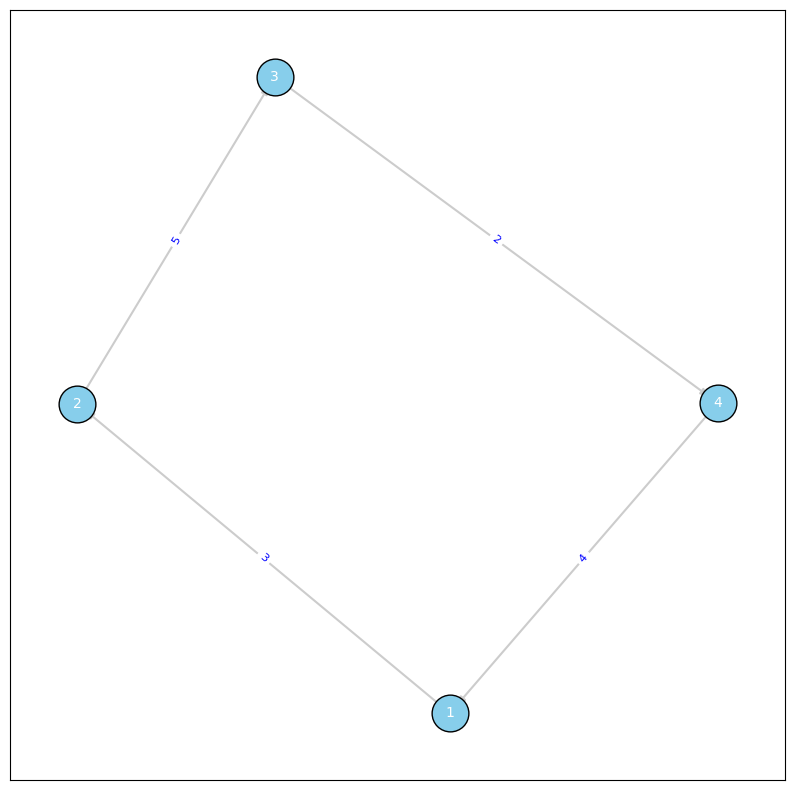

Graph saved to ./output/group-graphs/ectel2024-WS2024-05-group-graph-3502.pdf


In [207]:
# Create a sample directed graph
G = nx.DiGraph()
G.add_edges_from([
    (1, 2, {'weight': 3}),
    (2, 3, {'weight': 5}),
    (3, 4, {'weight': 2}),
    (4, 1, {'weight': 4}),
])

# Define parameters
output_path = "./output"
semester = "WS2024"
group_id = 3502

# Call the function
plot_graph_network(G, group_id)


In [211]:
import networkx as nx
import os

# Step 1: Get all unique groups
all_groups = author_relations['group'].drop_duplicates().sort_values().tolist()

# Step 2: Make a dry run for one group
# Example:
df_cohesion_net = author_relations[author_relations['group'] == all_groups[1]]
plotgr = get_cohesion_graph(df_cohesion_net)
plot_graph_network(plotgr, 3502)
measure = pd.DataFrame([get_group_graph_measures(plotgr, 3502)]).T



KeyError: -1

In [ ]:

# Step 3: Iterate over all groups to build the graph and calculate the measures
graph_measures_list = []

for i, group in enumerate(all_groups):
    print(f'Compute graph of group {group}: {i+1}/{len(all_groups)}')

    # Create graph and calculate measures
    df_cohesion_net = author_relations[author_relations['group'] == group]
    plotgr = get_cohesion_graph(df_cohesion_net)  # Generate cohesion graph

    # Store graph as plot
    plot_graph_network(plotgr, group)

    # Compute graph measures
    measure = get_group_graph_measures(plotgr, group)

    # Append results
    graph_measures_list.append(measure)

# Convert results to DataFrame
graph_measures = pd.DataFrame(graph_measures_list)

# Step 4: Inspect and save result
output_file = os.path.join(output_path, f'ectel24-{semester}-05-group-graph-measures.csv')
graph_measures.to_csv(output_file, index=False)

print(f"Graph measures saved to {output_file}")

# Load the data again (if needed)
graph_measures = pd.read_csv(output_file)

# Display the first few rows
graph_measures.head()
